In [23]:
import json
import re
import requests
import numpy as np

**Data Collection**

In [24]:
# Download SQuAD(Stanford Question Answering Dataset) dataset
squad_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
response = requests.get(squad_url)
squad_data = response.json() #This method parses the JSON content from the HTTP response and converts it into a Python dictionary.

In [25]:
print(squad_data.keys())

dict_keys(['version', 'data'])


**Data Preprocessing**

In [26]:
# Define a function to preprocess text
def preprocess_text(text):

    # Convert text to lowercase
    text = text.lower()

    return text

In [27]:
# Preprocessing on squad data
def preprocess_squad_data(squad_data):
    contexts = []
    questions = []
    answers = []

    for topic in squad_data['data']:
        for paragraph in topic['paragraphs']:
            context = preprocess_text(paragraph['context'])
            for qa in paragraph['qas']:
                question = preprocess_text(qa['question'])
                if 'is_impossible' in qa and qa['is_impossible']:
                    continue
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(preprocess_text(answer['text']))

    return contexts, questions, answers

contexts, questions, answers = preprocess_squad_data(squad_data)

In [28]:
# Print some examples to visualize the data

for i in range(3):
    print(f"Context {i+1}: {contexts[i]}")
    print(f"Question {i+1}: {questions[i]}")
    print(f"Answer {i+1}: {answers[i]}")
    print()

Context 1: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
Question 1: when did beyonce start becoming popular?
Answer 1: in the late 1990s

Context 2: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in va

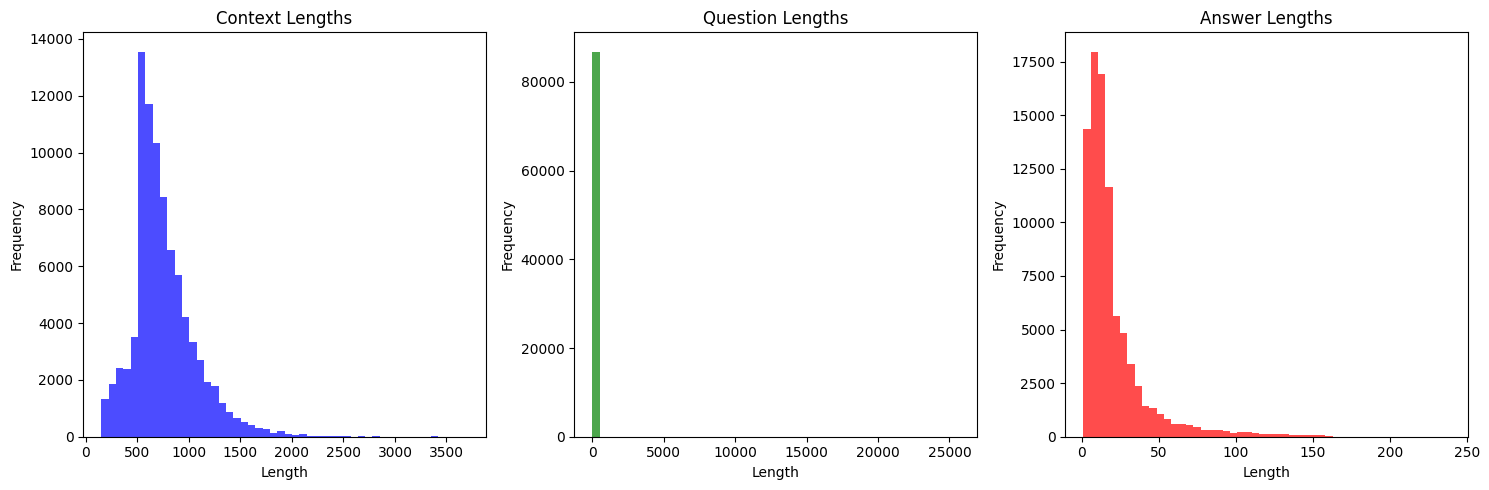

In [29]:
import matplotlib.pyplot as plt

# Calculate lengths
context_lengths = [len(seq) for seq in contexts]
question_lengths = [len(seq) for seq in questions]
answer_lengths = [len(seq) for seq in answers]

# Plot histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(context_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Context Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(question_lengths, bins=50, color='green', alpha=0.7)
plt.title('Question Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(answer_lengths, bins=50, color='red', alpha=0.7)
plt.title('Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Tokenization and Padding on Data**

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(contexts + questions + answers)
vocab_size = len(tokenizer.word_index) + 1 # Adding 1 accounts for the padding index.

max_context_len = 400
max_question_len = 50

context_sequences = tokenizer.texts_to_sequences(contexts)
context_padded = pad_sequences(context_sequences, maxlen=max_context_len, padding='post')
question_sequences = tokenizer.texts_to_sequences(questions)
question_padded = pad_sequences(question_sequences, maxlen=max_question_len, padding='post')
answer_sequences = tokenizer.texts_to_sequences(answers)
answer_padded = np.array([seq[0] if len(seq) > 0 else 0 for seq in answer_sequences])

In [31]:
answer_padded

array([    4,  3368,   965, ..., 27414,  2780,  1997])

In [32]:
print("Data shapes:")
print(f"Contexts: {context_padded.shape}")
print(f"Questions: {question_padded.shape}")
print(f"Answer: {answer_padded.shape}")

Data shapes:
Contexts: (86821, 400)
Questions: (86821, 50)
Answer: (86821,)


In [33]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

context_train, context_test, question_train, question_test, answer_train, answer_test = train_test_split(
    context_padded, question_padded, answer_padded, test_size=0.2, random_state=42
)

In [34]:
# Print a few examples from the input arrays
print("First few context sequences:", context_train[:3])
print("First few question sequences:", question_train[:3])
print("First few answer sequences:", answer_train[:3])

First few context sequences: [[  14  102  324 ...    0    0    0]
 [  14  258  510 ...    0    0    0]
 [ 114   63 5855 ...    0    0    0]]
First few question sequences: [[  34 2685  436  526    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  76   41   80   17   14    1 3261  341    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  79  140 9096 6221 7025   13  122  357    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
First few answer sequences: [20423 10862    20]


In [35]:
# # Instantiate the tuner
# tuner = kt.Hyperband(build_model,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=2,
#                      directory='my_dir',
#                      project_name='qa_lstm')

In [36]:
# Search for the best hyperparameters
# tuner.search([context_padded, question_padded], answer_padded,
#              epochs=10,
#              validation_split=0.2,
#              callbacks=[early_stopping])

In [52]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, Concatenate, Activation, Dot, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(vocab_size, max_context_len, max_question_len):
    # Input layers
    #  input layers with shapes 
    context_input = Input(shape=(max_context_len,), dtype='int32', name='context_input')
    question_input = Input(shape=(max_question_len,), dtype='int32', name='question_input')

    # Embedding layers
    # used to convert integer indices into dense vectors 
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_context_len)
    context_embedded = embedding_layer(context_input)
    question_embedded = embedding_layer(question_input)

    # LSTM layers
    shared_lstm = Bidirectional(LSTM(128, return_sequences=True))
    context_lstm = shared_lstm(context_embedded)
    question_lstm = shared_lstm(question_embedded)

    # Attention mechanism
    # Dot used to compute attention scores between context_lstm and question_lstm.
    attention = Dot(axes=[2, 2], name='attention_dot')([context_lstm, question_lstm]) 
    # attenttion normalizes the attention scores to produce attention weights 
    attention = Activation('softmax', name='attention_softmax')(attention)
    context_attention = Dot(axes=[2, 1], name='context_attention')([attention, question_lstm])
    context_question = Concatenate(name='context_question')([context_lstm, context_attention])

    # Batch normalization
    # normalizes the activations of context_question 
    context_question = BatchNormalization()(context_question)

    # LSTM for combined context and question
    combined_lstm = Bidirectional(LSTM(128))(context_question)
    dropout = Dropout(0.5)(combined_lstm)

    dense = Dense(256, activation='relu')(dropout)
    dense = Dropout(0.5)(dense) # Dropout are applied after LSTM and dense layers to prevent overfitting.
    output = Dense(vocab_size)(dense)
    answer = Activation('softmax')(output)

    # Build model
    model = Model(inputs=[context_input, question_input], outputs=answer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_model(vocab_size, max_context_len, max_question_len)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 context_input (InputLayer)  [(None, 400)]                0         []                            
                                                                                                  
 question_input (InputLayer  [(None, 50)]                 0         []                            
 )                                                                                                
                                                                                                  
 embedding_2 (Embedding)     multiple                     1176652   ['context_input[0][0]',       
                                                          8          'question_input[0][0]']      
                                                                                            

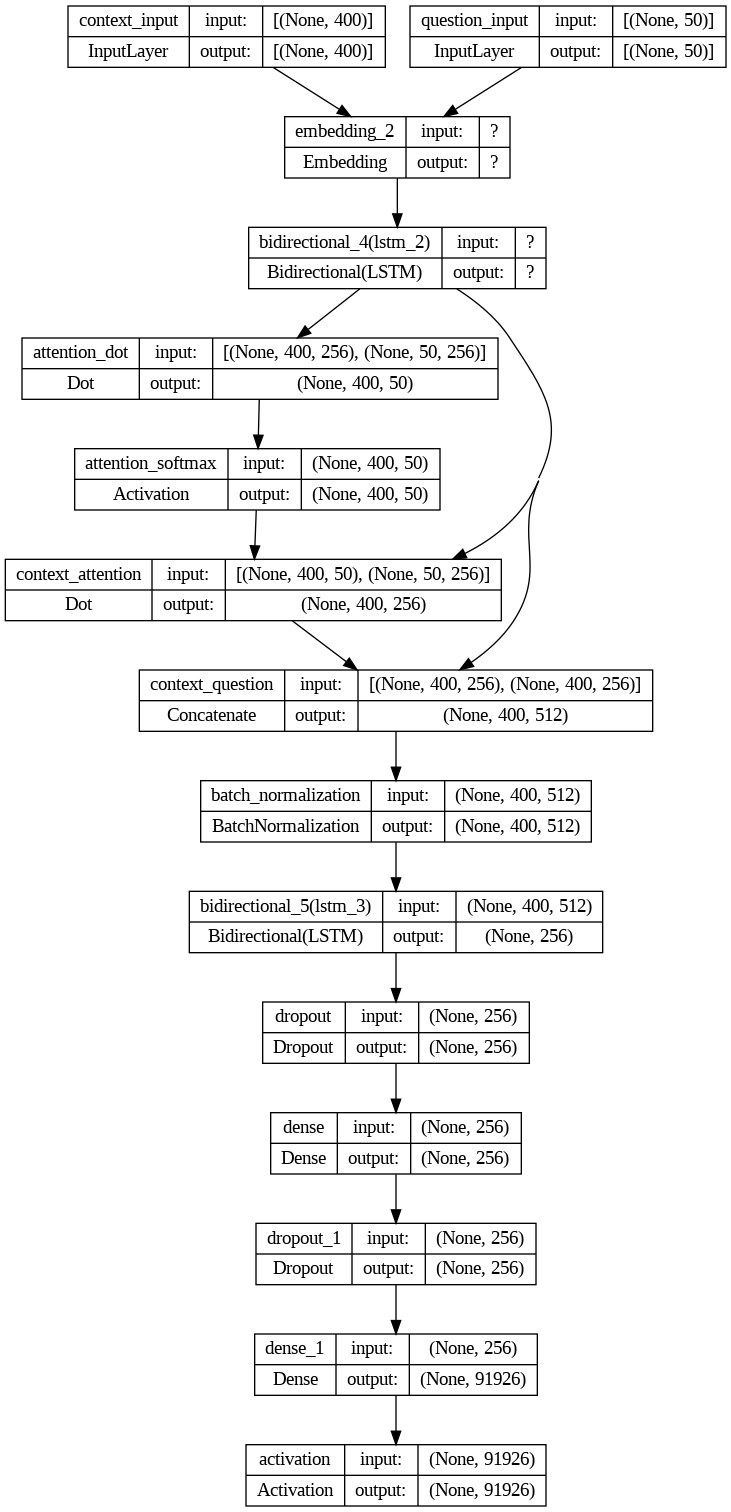

In [53]:
# Visualize the model
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss'),
    ModelCheckpoint('best_simple_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [55]:
answer_train = answer_train.reshape(-1)
answer_test = answer_test.reshape(-1)

In [ ]:
history = model.fit([context_train, question_train], answer_train,
                    batch_size=32,
                    epochs=120,
                    validation_data=([context_test, question_test], answer_test),
                    callbacks=callbacks)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Save model
model_path = "/content/model"
weights_path = "/content/weight"
model.save(model_path)
model.save_weights(weights_path)

In [66]:
from tensorflow.keras.models import load_model

# Path to your saved model file
model_path = '/content/best_simple_model.h5'

# Load the model
model = load_model(model_path)
model.load_weights(model_path)

**Test with new data**

In [90]:
new_contexts = 'John left the kitchen. Sandra dropped the football in the garden.'
new_questions = 'Is the football in the garden?'

In [91]:
# Preprocess new data
new_contexts_processed = new_contexts.lower()
new_questions_processed = new_questions.lower()

In [92]:
# Tokenize and pad new data
tokenizer = Tokenizer()
new_context_sequences = tokenizer.texts_to_sequences([new_contexts_processed])
new_question_sequences = tokenizer.texts_to_sequences([new_questions_processed])

In [93]:
max_context_len = 400
max_question_len = 50

new_context_padded = pad_sequences(new_context_sequences, maxlen=max_context_len, padding='post')
new_question_padded = pad_sequences(new_question_sequences, maxlen=max_question_len, padding='post')


In [96]:
# Make predictions
new_predictions = model.predict([new_context_padded, new_question_padded])
predicted_index = np.argmax(new_predictions, axis=1)

1/1 [==============================] - 0s 52ms/step


In [100]:
# Convert predicted indices to text
predicted_answers = []
for predicted_index in predicted_index:
    predicted_answer = tokenizer.index_word.get(predicted_index, '')
    predicted_answers.append(predicted_answer)

In [ ]:
# Display the predictions
for context, question, prediction in zip([new_contexts], [new_questions], predicted_answers):
    print(f"Context: {context}")
    print(f"Question: {question}")
    print(f"Predicted Answer: {prediction}")